In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
from sklearn.metrics import r2_score
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/computer network/project/simulation2.csv")

In [4]:
df.head()

,bw,delay,loss,queue,packet_loss_ratio,rtt,jitter,throughput
0,5,6.182359,0,50,50,148.60,24.419255,2.5
1,5,26.188937,1,100,50,327.40,56.760902,2.5
2,5,23.303086,1,100,50,306.60,36.800815,2.5
3,50,26.462738,0,200,50,417.40,45.153073,25.0
4,20,16.910455,2,100,50,139.32,61.501602,10.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bw                 576 non-null    int64  
 1   delay              576 non-null    float64
 2   loss               576 non-null    int64  
 3   queue              576 non-null    int64  
 4   packet_loss_ratio  576 non-null    int64  
 5   rtt                574 non-null    float64
 6   jitter             576 non-null    float64
 7   throughput         576 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 36.1 KB


In [6]:
df.describe()

,bw,delay,loss,queue,packet_loss_ratio,rtt,jitter,throughput
count,576.000000,576.000000,576.00000,576.000000,576.000000,574.000000,576.000000,576.000000
mean,21.119792,26.926731,1.90625,117.187500,51.892361,309.010780,48.495307,10.003472
std,18.019445,12.755850,1.85610,62.273503,18.351037,152.606166,32.627624,9.984988
min,5.000000,5.000587,0.00000,50.000000,0.000000,49.400000,0.000000,0.000000
25%,5.000000,15.646056,0.00000,50.000000,40.000000,171.337500,27.218098,3.000000
50%,10.000000,27.100703,1.00000,100.000000,50.000000,306.800000,42.190828,5.000000
75%,50.000000,37.522043,2.00000,200.000000,60.000000,421.553571,64.211714,14.000000
max,50.000000,49.842645,5.00000,200.000000,100.000000,724.166667,237.330290,40.000000


In [7]:
print("Önceki satır sayısı:", len(df))
df = df.dropna(subset=["rtt"])
print("Sonraki satır sayısı:", len(df))

Önceki satır sayısı: 576
Sonraki satır sayısı: 574


In [8]:
def find_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] < lower) | (df[column] > upper)]

for col in df.columns:
    outliers = find_outliers(col)
    print(f"\n🔍 {col} sütununda aykırı değer sayısı: {len(outliers)}")


🔍 bw sütununda aykırı değer sayısı: 0

🔍 delay sütununda aykırı değer sayısı: 0

🔍 loss sütununda aykırı değer sayısı: 0

🔍 queue sütununda aykırı değer sayısı: 0

🔍 packet_loss_ratio sütununda aykırı değer sayısı: 2

🔍 rtt sütununda aykırı değer sayısı: 0

🔍 jitter sütununda aykırı değer sayısı: 17

🔍 throughput sütununda aykırı değer sayısı: 25


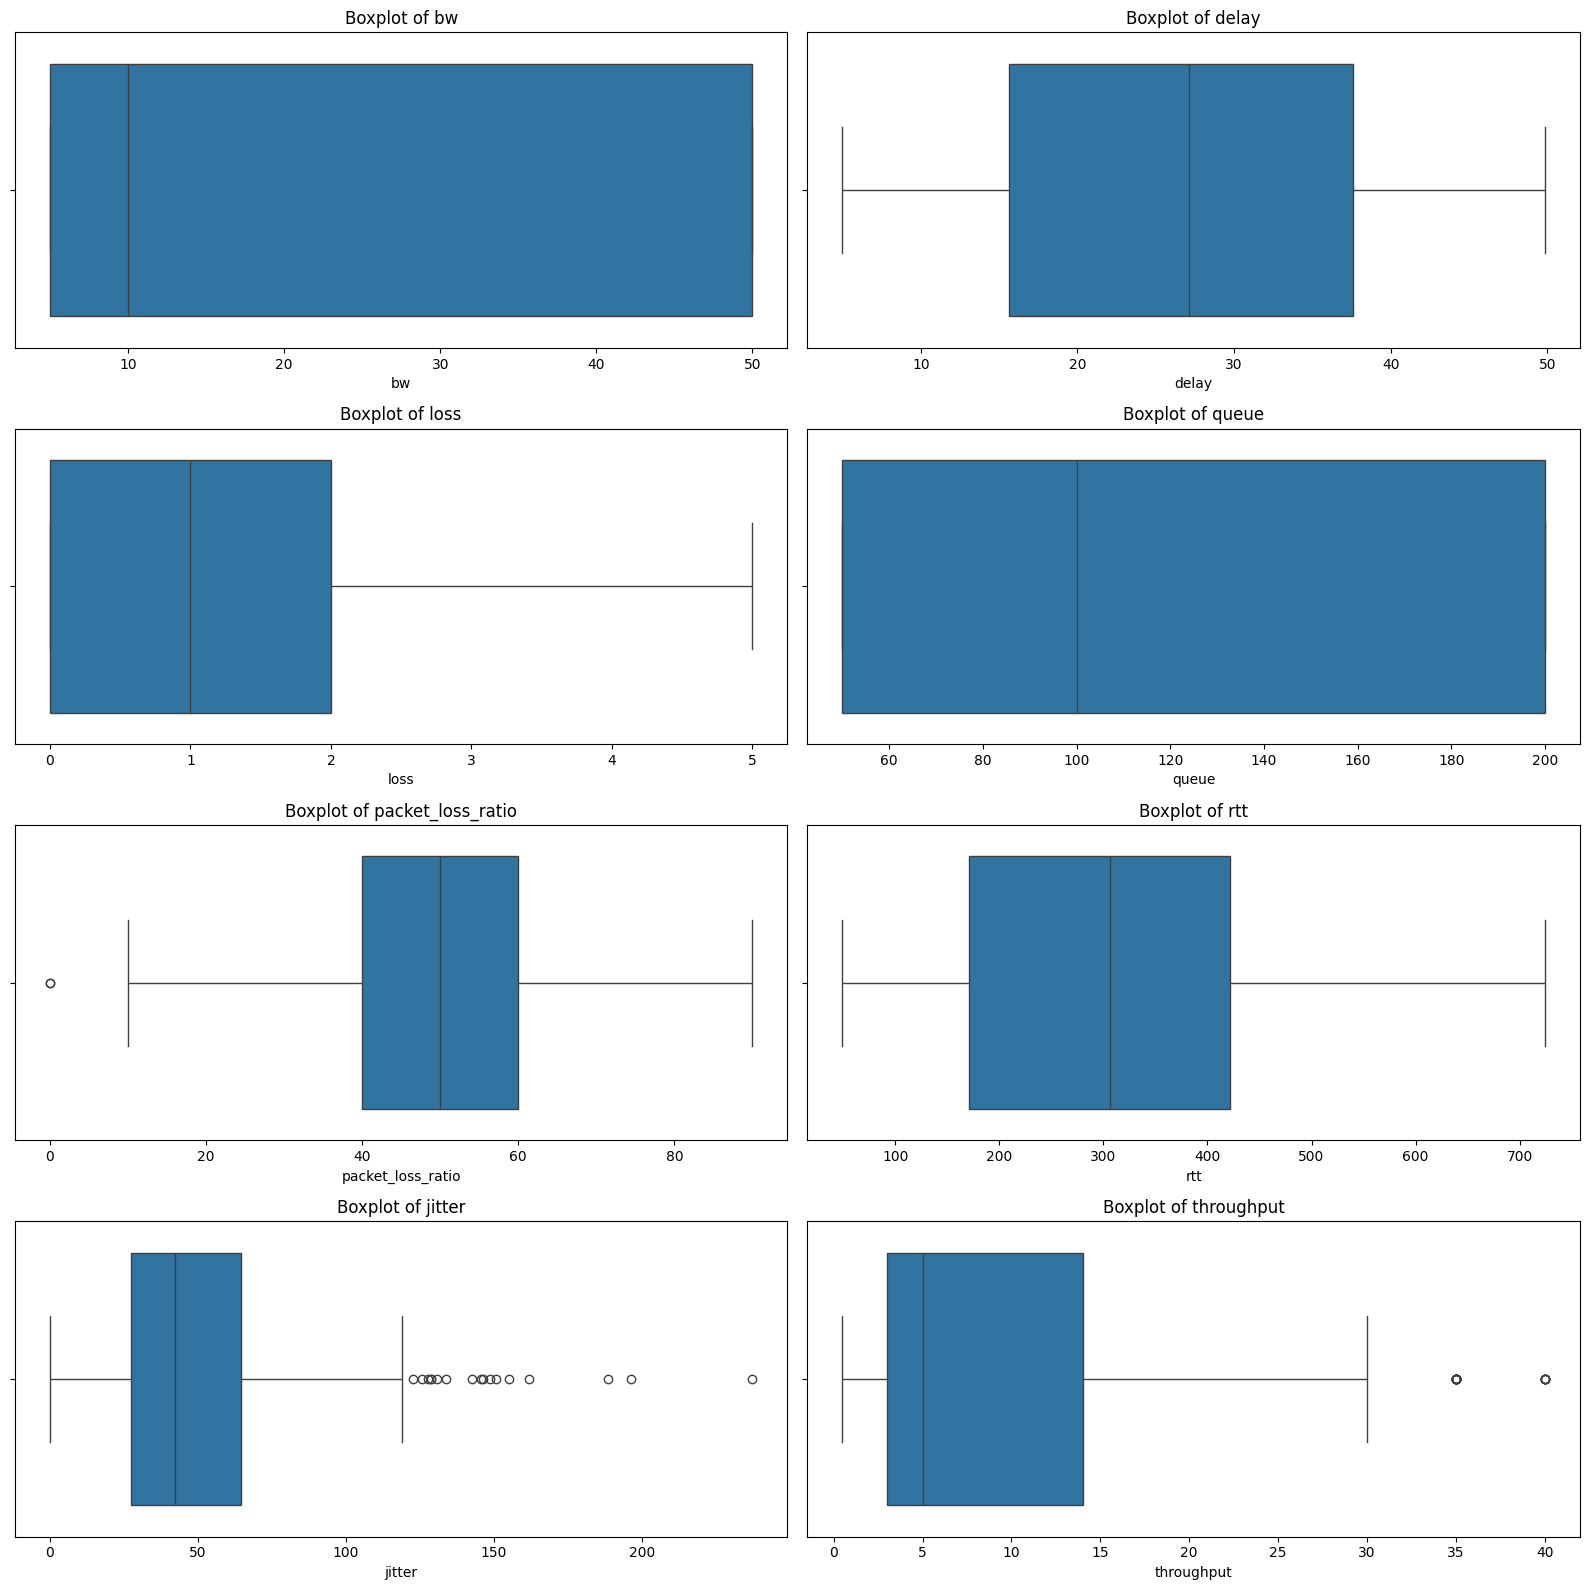

In [9]:
numeric_cols = df.columns
rows = math.ceil(len(numeric_cols)/2)

plt.figure(figsize=(16, rows*4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 2, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

In [10]:
def iqr_capping(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

In [11]:
columns_to_cap = ['throughput']
for col in columns_to_cap:
    if col in df.columns:
        df = iqr_capping(df, col)
        print(f"'{col}' sütununda aykırı değerler IQR ile sınırlara çekildi.")

'throughput' sütununda aykırı değerler IQR ile sınırlara çekildi.


In [12]:
columns_to_transform = ['rtt', 'jitter']
for col in columns_to_transform:
    if col in df.columns:
        df[col] = np.log1p(df[col]) # Log dönüşümü uygulandı

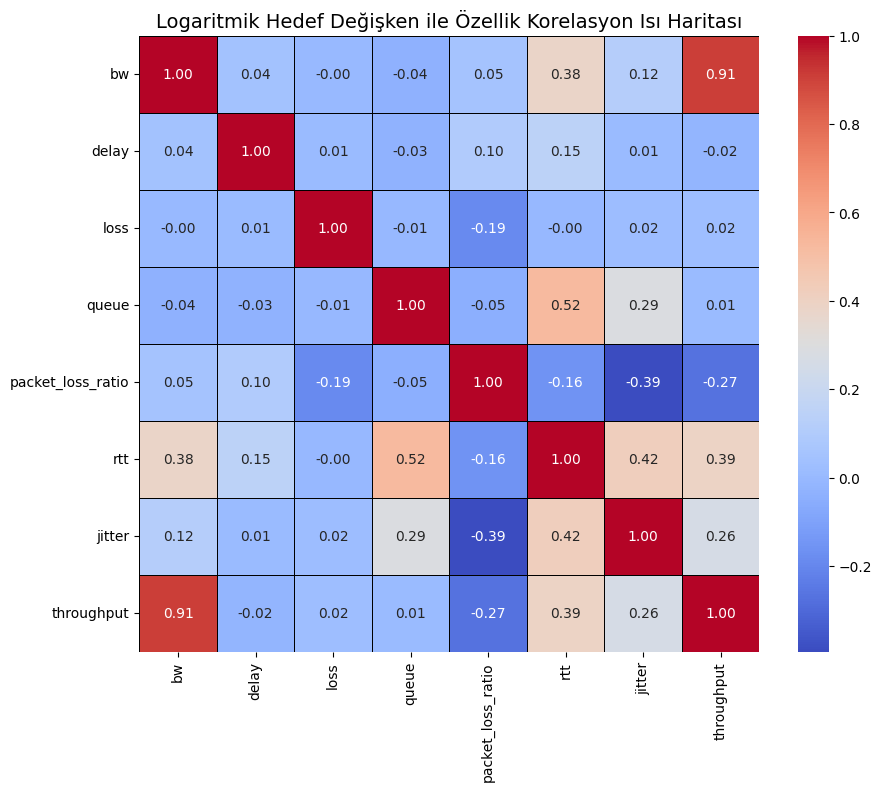

In [13]:
correlation_matrix = df.corr()

# 2. Isı Haritasını Görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar=True,
    linewidths=.5,
    linecolor='black'
)
plt.title('Logaritmik Hedef Değişken ile Özellik Korelasyon Isı Haritası', fontsize=14)
plt.show()

In [15]:
TARGET_COLUMN = "rtt"
SELECTED_FEATURES = ["bw", "queue", "jitter","throughput"]

In [16]:
# Bağımlı Değişken (Y)
Y = df[TARGET_COLUMN]

# Bağımsız Değişkenler (X) - Sadece seçilen özellikleri içerir
X = df[SELECTED_FEATURES]

In [17]:
# Standardizasyon Uygulama
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)
print("Seçilen özelliklere Standardizasyon uygulandı.")

Seçilen özelliklere Standardizasyon uygulandı.


In [18]:
# Eğitim/Test Ayırma
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42
)

In [19]:
# --- 1. Doğrusal Regresyon (Linear Regression) ---
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)
print("Doğrusal Regresyon Eğitimi Tamamlandı.")
models = {'Linear Regression': lr_model}

Doğrusal Regresyon Eğitimi Tamamlandı.


In [20]:
# --- 2. K-En Yakın Komşu Regresyonu (KNN Regressor) ve Hiperparametre Optimizasyonu ---
knn_params = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
knn_gs = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=knn_params,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=0,
    n_jobs=-1
)
knn_gs.fit(X_train, Y_train)
knn_best_model = knn_gs.best_estimator_
models['KNN Regressor'] = knn_best_model
print(f"KNN Regresyon Eğitimi ve Optimizasyonu Tamamlandı. En iyi k: {knn_gs.best_params_['n_neighbors']}")

KNN Regresyon Eğitimi ve Optimizasyonu Tamamlandı. En iyi k: 3


In [21]:
# --- 3. Destek Vektör Regresyonu (SVR) ---
svr_params = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2]
}
svr_gs = GridSearchCV(SVR(), param_grid=svr_params, scoring='neg_mean_squared_error', cv=3, verbose=0, n_jobs=-1)
svr_gs.fit(X_train, Y_train)
models['SVR Regressor'] = svr_gs.best_estimator_
print(f"SVR Regresyon Eğitimi Tamamlandı. En iyi C: {svr_gs.best_params_['C']}")

SVR Regresyon Eğitimi Tamamlandı. En iyi C: 10


In [22]:
# --- 4. Decision Tree Regressor (Karar Ağacı) ---
dt_params = {'max_depth': [5, 10, 15], 'random_state': [42]} # Aşırı uydurmayı engellemek için derinlik optimize edilir
dt_gs = GridSearchCV(DecisionTreeRegressor(), param_grid=dt_params, scoring='neg_mean_squared_error', cv=3, verbose=0, n_jobs=-1)
dt_gs.fit(X_train, Y_train)
models['Decision Tree'] = dt_gs.best_estimator_
print(f"Karar Ağacı Eğitimi Tamamlandı. En iyi derinlik: {dt_gs.best_params_['max_depth']}")

Karar Ağacı Eğitimi Tamamlandı. En iyi derinlik: 5


In [23]:
#  --- 5. Random Forest Regressor (Rastgele Orman) ---
rf_params = {
    'n_estimators': [50, 100],  # Kullanılacak ağaç sayısı
    'max_depth': [5, 10],       # Ağacın maksimum derinliği
    'random_state': [42]
}
rf_gs = GridSearchCV(RandomForestRegressor(), param_grid=rf_params, scoring='neg_mean_squared_error', cv=3, verbose=0, n_jobs=-1)
rf_gs.fit(X_train, Y_train)
models['Random Forest'] = rf_gs.best_estimator_
print(f"Random Forest Eğitimi ve Optimizasyonu Tamamlandı. En iyi derinlik: {rf_gs.best_params_['max_depth']}")

Random Forest Eğitimi ve Optimizasyonu Tamamlandı. En iyi derinlik: 5


In [24]:
results_df = pd.DataFrame(columns=['MAE', 'RMSE', 'R2'])
predictions = {}

In [25]:
for name, model in models.items():
    Y_pred = model.predict(X_test)
    predictions[name] = Y_pred

    mae = mean_absolute_error(Y_test, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    r2 = r2_score(Y_test, Y_pred)

    results_df.loc[name] = [mae, rmse, r2]

print("Modellerin Performans Metrikleri:")
print(results_df)

Modellerin Performans Metrikleri:
                        MAE      RMSE        R2
Linear Regression  0.314939  0.382776  0.508423
KNN Regressor      0.104608  0.151643  0.922848
SVR Regressor      0.096635  0.133700  0.940026
Decision Tree      0.104339  0.137720  0.936365
Random Forest      0.095331  0.127589  0.945383
